In [1]:
!pip install replay-rec --quiet
!pip install implicit --quiet
!pip install lightfm --quiet
!pip install apyori --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.8.0 requires dask==2024.8.0, but you have dask 2024.12.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 14.6 MB/s e

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import scipy.sparse as sparse
import scipy
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')

from replay.metrics import Experiment
import implicit # для ALS
from datasets import load_dataset
import matplotlib.pyplot as plt

# **Модели матричной факторизации**

## **<span style='color:#686dec'>1 | Задание</span>**

- Выберите любой понравившийся вам набор данных с количеством рейтингов более 1М по ссылке: https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023
- Проведите базовый EDA - распределения рейтингов, количество уникальных товаров и т.д. При необходимости фильтруйте данные.
- Сделайте разбиение данных на train и test методом leave-one-out.
- На основании вашего датасета постройте 3-4 рекомендательных модели. Можно включить простой бейзлайн типа модели, рекомендующей самые популярные товары, а также использовать библиотеку implicit и другие.
- Оцените качество полученных рекомендаций по метрикам HR@10, MRR@10, NDCG@10, coverage.
- Напишите выводы о проделанной работе: качество какой модели оказалось лучше, почему.

## **<span style='color:#686dec'>2 | Чтение данных</span>**

### **Датасет взаимодействии**

Для датасета, загружаем данные по взаимодейстию покупателя с товарами програмного обеспечения

In [3]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", 
                       "raw_review_Software", 
                       trust_remote_code=True)
dataset_df = dataset['full'].to_pandas()

# Конвертируем datetime в ms
dataset_df['timestamp'] = pd.to_datetime(dataset_df['timestamp'], unit='ms')

dataset_df.drop(['title','text','images','helpful_vote','verified_purchase'],axis=1,inplace=True)
dataset_df = dataset_df.rename(columns={'parent_asin':'item_id'})

README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Software.jsonl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Удаляем дубликаты для комбинации трех колонок **`user_id`**, **`item_id`**, **`timestamp`**

In [4]:
# подсчет дубликатов 
dataset_df[['user_id','item_id','timestamp']].value_counts()

user_id                       item_id     timestamp              
AGALPU5ARZEK75CGKYELK232AHGA  B06XP4F49R  2019-01-23 22:01:29.630    27
AE3QHFBC2YC4YRQJZWSP2Z7LUVNA  B00BJ4ETBW  2015-04-25 07:45:40.000    11
AHK7CJWVLIXTRDTPJ5ZEEL56UCVA  B01LXOU5PM  2018-09-26 00:17:44.554    10
AGCHXQUQ54YTXOGYRWFSV4MQFMQA  B00O109QX2  2018-04-08 15:37:17.347    10
AGNGFKMPODAP7XWAGIC42WCSGBMQ  B00IG2DOKM  2016-08-18 13:08:27.000    10
                                                                     ..
AFEUXIC24P7FP4T6M6M5CZO33NKQ  B00DVKOYBM  2015-09-07 20:33:11.000     1
AFEUXHN4I3PIA6WYZQT2SEJUSXWA  B00XGNNN52  2017-07-29 18:00:39.829     1
                              B0081JPTXK  2013-04-03 18:31:55.000     1
                              B007TBAQCK  2016-07-23 16:24:17.000     1
AHZZZYHANWL2OW5PGXDOBUTJXCTA  B07RCG9SRL  2020-04-23 04:02:34.597     1
Name: count, Length: 4829120, dtype: int64

In [5]:
# удаляем эти дубликаты (одновременно преобрел несколько товаров)
dataset_df.drop_duplicates(subset=['user_id','item_id','timestamp'],inplace=True)

### **Датасет товаров**

- **`parent_asin`** : идентификатор (программное обеспечение) товара
- **`user_id`** : Идентификатор Пользователь

In [6]:
meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", 
                    "raw_meta_Software",
                    trust_remote_code=True)
ldf = meta["full"].to_pandas()
ldf = ldf.rename(columns={'parent_asin':'item_id'})
ldf.drop(['features','description','images','videos','details',
          'bought_together','subtitle','author','categories'],axis=1,inplace=True)
ldf = ldf[~(ldf['price'] == 'None')]
ldf['price'] = ldf['price'].astype('float')
ldf.head()

meta_Software.jsonl:   0%|          | 0.00/256M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

,main_category,title,average_rating,rating_number,price,store,item_id
0,Appstore for Android,Accupressure Guide,3.6,NaN,0.00,mAppsguru,B00VRPSGEO
1,Appstore for Android,Ankylosaurus Fights Back - Smithsonian's Prehi...,4.0,NaN,2.99,"Oceanhouse Media, Inc",B00NWQXXHQ
2,Appstore for Android,Mahjong 2015,3.1,NaN,0.00,sophiathach,B00RFKP6AC
3,Appstore for Android,Jewels Brick Breakout,4.2,NaN,0.00,Bad Chicken,B00SP2QU0E
4,Appstore for Android,Traffic Police: Off-Road Cub,3.3,NaN,0.00,Dast 2 For Metro,B01DZIT64O


## **<span style='color:#686dec'>3 | Разведовательный анализ</span>**

### **Распределение рейтинг пользователей**

Рейтинги которые ставя пользователи 

<Axes: >

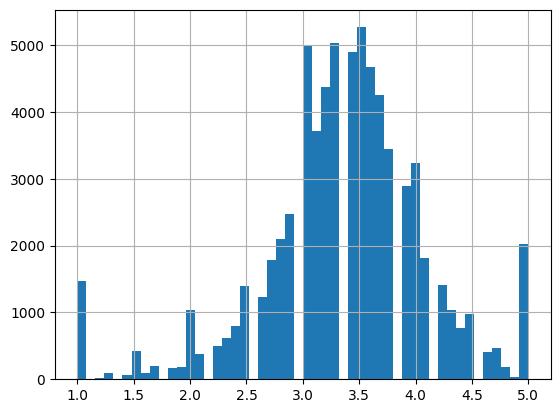

In [7]:
# Среднее рейтинга товара
ldf.average_rating.hist(bins=50)

### **Количество рейитингов**

Количество рейтингов у пользователя

(0.0, 100.0)

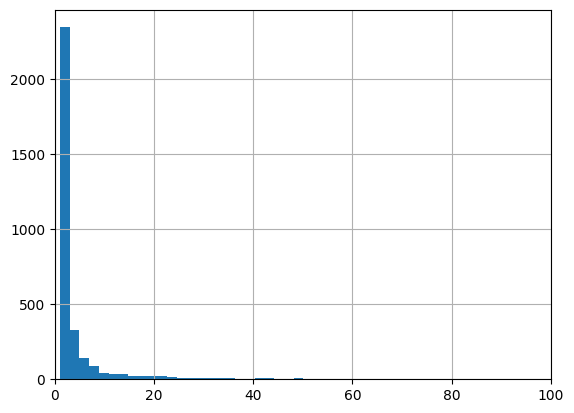

In [8]:
# Среднее количество ретингов
ldf.rating_number.value_counts().hist(bins=3000)
plt.xlim(0,100)

In [9]:
df = dataset_df.copy()

In [10]:
# main category
ldf['main_category'].value_counts()

main_category
Appstore for Android    67849
Software                 2922
Home Audio & Theater        1
Computers                   1
Name: count, dtype: int64

(0.0, 100.0)

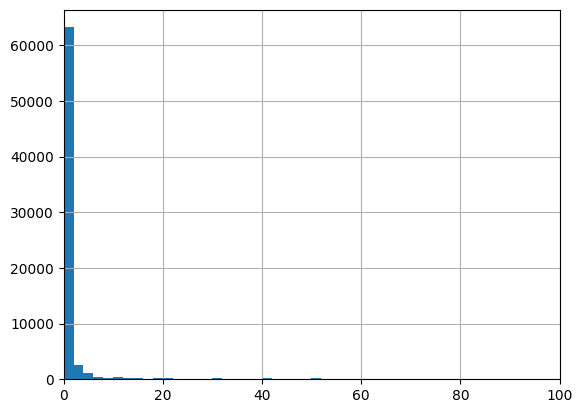

In [11]:
ldf['price'].hist(bins=1000)
plt.xlim(0,100)

## **<span style='color:#686dec'>4 | Преподработка</span>**

### **a) Фильтрация данных по признаку фичей**

Отфильтруем по колонкам признаков фичей:
- **`average_price`** : Средний рейтинг товара
- **`rating_number`** : Количество отзывов


Оставляем только взамидействии пользователей с этими товарами, остальные удаляем
- Цель нашей рекомендации, предложить пользователю товары которые хорошо оценивали и количество оценок тоже много

In [12]:
'''

Фильтрация по фичам [ldf]

'''

print('уникальных пользователей: ',df['user_id'].nunique())
print('Количество взаимодействии в исходной выборке ',df.shape[0])
print('Количество товаров в исходной выборке ',ldf.shape[0])
# Количество товаров в исходной выборке

# Средний рейтинг тована > 3.5
# Количество рейтингов > 50 раз
ldf = ldf[(ldf['average_rating'] >= 4.0) & (ldf['rating_number'] > 500)]

df = df[df['item_id'].isin(ldf['item_id'])]
print('Количество взаимодействии после фильтрации ',df.shape[0])
print('Количество товаров после фильтрации ',ldf.shape[0])

уникальных пользователей:  2589466
Количество взаимодействии в исходной выборке  4829120
Количество товаров в исходной выборке  70985
Количество взаимодействии после фильтрации  1545391
Количество товаров после фильтрации  1487


In [13]:
print('уникальных пользователей: ',df['user_id'].nunique())

уникальных пользователей:  1133626


### **b) Фильтрация данных по взаимодействиям**

Фильруем по данным взаимодействии пользователей и товаром:
- фильтруем пользователей у которых мало взаимодейсвии
- фильтруем товары которых мало покупали

In [14]:
'''

Фильтрации по взаимодействиям [df]

'''

# Количество взаимодействии для пользователя
user_counts = df['user_id'].value_counts()

# Пользователи у которых больше n пользователей
user_count_limit_users = user_counts[user_counts > 10].index
df = df[df['user_id'].isin(user_count_limit_users)]
print('Количество взаимодействии после фильтрации ',df.shape[0])

# Товары которыйх покупали мельше n раз
item_counts = df['item_id'].value_counts()
df = df[~df['item_id'].isin(item_counts[item_counts < 30].index)]
print('Размер датасета после фильтрации товаров: ',df.shape[0])

Количество взаимодействии после фильтрации  42234
Размер датасета после фильтрации товаров:  35520


### **Расспределение рейтингов**

In [15]:
df['rating'].value_counts(normalize=True)*100

rating
5.0    60.526464
4.0    12.722410
3.0    11.627252
1.0    11.221847
2.0     3.902027
Name: proportion, dtype: float64

### **Преобразуем IDs**

Преобразуем идентификаторы в датасетах, чтобы они начинались с 0

In [16]:
'''

Reset user_id, item_id index to start from 0

'''

all_users = df['user_id'].unique().tolist()  # all unique users in ratings data
all_items = df['item_id'].unique().tolist() # all unique movies in ratings data

n_users = df['user_id'].nunique() # number of unique users
n_items = df['item_id'].nunique() # number of unique movies

user_id2idx = dict(zip(all_users, range(n_users)))
item_id2idx = dict(zip(all_items, range(n_items)))

df['user_id'] = df['user_id'].map(user_id2idx) # redefine user id  (for better interpretation)
df['item_id'] = df['item_id'].map(item_id2idx) # redefine movie id (for better interpretation)

In [17]:
print(all_items[:5]) # all unique items found in user/item interaction dataset
print(n_items,'unique items found in user/item interaction dataset after filtration')
print(ldf.shape[0],'unique items found in metadata')
print(df.shape[0],'number of interactions')

['B075VFR5DB', 'B0117U0G3M', 'B012GOSOD2', 'B00LV4D70O', 'B0094BB4TW']
223 unique items found in user/item interaction dataset after filtration
1487 unique items found in metadata
35520 number of interactions


In [18]:
# convert item_id 
ldf = ldf[ldf['item_id'].isin(all_items)]
ldf['item_id'] = ldf['item_id'].map(item_id2idx)

### **Создаем подвыборки**

Разбиваем данные на две подвыборки, `train` и `test`, будем импользовать первую для обучения моделей и формирования рекомендации

In [19]:
USER_COL = 'user_id'
ITEM_COL = 'item_id'
TIMESTAMP = 'timestamp'

def train_test_split(
    clickstream_df,
    test_quantile=0.9
):
    """
    Split clickstream by date.
    """
    clickstream_df = clickstream_df.sort_values([USER_COL, TIMESTAMP])
    test_timepoint = clickstream_df[TIMESTAMP].quantile(
    q=test_quantile, interpolation='nearest'
    )
    test = clickstream_df.query(f'{TIMESTAMP} >= @test_timepoint')
    train = clickstream_df.drop(test.index)

    test = test[test[USER_COL].isin(train[USER_COL])]
    test = test[test[ITEM_COL].isin(train[ITEM_COL])]

    test_full_history = test.sort_values([USER_COL, TIMESTAMP]).groupby(USER_COL)
    last_item = test_full_history.tail(1)
    test_history = test_full_history.head(-1)

    test = pd.concat([train, test_history])

    test.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)
    return train, test, last_item

train,test,last_item = train_test_split(df)

print('Training ',train.shape[0])
print('Test ',test.shape[0])
print('Last Item ',last_item.shape[0])

Training  31967
Test  33102
Last Item  507


## **<span style='color:#686dec'>4 | Моделирование</span>**

### **а) Самые популярные**

Из выборки, выберем топ n количество товаров, которые будем рекоммендовать всем, строим рекомендации на основе эвристик

In [20]:
'''

Most popular items (top 10)

'''

from collections import Counter

count_items = Counter(train['item_id'])
count_items = [*count_items.items()]
count_items.sort(key=lambda x: x[1], reverse=True)

pred_items = [k for k, v in count_items[:10]]
pred_counter = test.copy()
pred_counter['item_id'] = [pred_items] * len(pred_counter)
pred_counter = pred_counter.drop_duplicates(subset='user_id').explode('item_id')
pred_counter = pred_counter[['user_id','item_id','rating']]
pred_counter.head()

,user_id,item_id,rating
0,0,36,5.0
0,0,35,5.0
0,0,4,5.0
0,0,55,5.0
0,0,60,5.0


### **b) Самые популярные с максимальным рейтингом**

Так же рассмотрим такой же вариант но с высокими рейтингами

In [21]:
from collections import Counter

count_items = Counter(train[train.rating == 5]['item_id'])
count_items = [*count_items.items()]
count_items.sort(key=lambda x: x[1], reverse=True)

pred_items = [k for k, v in count_items[:10]]
pred_highest = test.copy()
pred_highest['item_id'] = [pred_items] * len(pred_highest)
pred_highest = pred_highest.drop_duplicates(subset='user_id').explode('item_id')
pred_highest = pred_highest[['user_id','item_id','rating']]
pred_highest.head()

,user_id,item_id,rating
0,0,55,5.0
0,0,36,5.0
0,0,4,5.0
0,0,98,5.0
0,0,71,5.0


### **c) Apriori**

Попробуем подход `apriori`, будем рекомендовать фильмы на основе патернов просмотров во у всех пользователей. Построив правила на основе гиперпараметров, находим пересечение между простотров фильмов пользователя и в правиле от `from`. Ecли пересечение есть, рекомендуем все последующие фильмы в правиле `to`   

In [22]:
# Все фильмы с рейтингом 3+
ldf = train[train.rating > 2].copy()
highest_ratings_user = ldf.groupby('user_id')['item_id'].apply(lambda r: ' '.join([str(A) for A in r]))
highest_ratings_user.head()

user_id
0                                  11 9 6 5 4 3 2
1                      18 17 16 15 14 13 8 3 4 12
2        17 29 28 27 26 25 16 24 23 22 21 4 20 19
3                                     22 24 32 30
4    29 49 48 47 46 45 44 42 41 40 39 38 37 36 14
Name: item_id, dtype: object

In [23]:
import apyori

# строим правила для последовательностей просмотров фильмов
association_rules = apyori.apriori(highest_ratings_user.apply(lambda r: r.split(' ')), 
                                   min_support=0.02, 
                                   min_confidence=0.1, 
                                   min_lift=2, 
                                   min_length=2)

In [24]:
# выводим правила
asr_df = pd.DataFrame(columns = ['from', 'to', 'confidence', 'support', 'lift'])
for item in association_rules:
    pair = item[0] 
    items = [x for x in pair]
    asr_df.loc[len(asr_df), :] =  ' '.join(list(item[2][0][0])), \
                                  ' '.join(list(item[2][0][1])),\
                                  item[2][0][2], item[1], item[2][0][3]

# правила (от)
print(asr_df.shape)
asr_df.head()

(1486, 5)


,from,to,confidence,support,lift
0,100,157,0.431034,0.028879,3.941537
1,100,36,0.614943,0.041201,2.042207
2,100,41,0.333333,0.022333,2.208333
3,100,55,0.678161,0.045437,2.41589
4,100,61,0.304598,0.020408,3.282325


In [25]:
# функция которая выводит рекомендации и метрику lift
def get_recom_aprio(x):
    
    result = []; lift= []; ii = 0
    for iii,row in asr_df.iterrows():
        watched = set(x['history'].split(' ')) # watched films
        froms = set(row['from'].split(' ')) # watched film rules
        overlap = set(x['history'].split(' ')) & set(row['from'].split(' '))

        if len(overlap) > 0:
            to_watch = [int(i) for i in row['to'].split(' ')]
            to_lifts = [row['lift']] * len(to_watch)
            result.extend(to_watch)
            lift.extend(to_lifts)
            ii+=1

        if(ii==10):
            break

    return result, lift 

df_highest_ratings_user = highest_ratings_user.to_frame()
df_highest_ratings_user.columns = ['history']
df_highest_ratings_user[['item_id','rating']] = df_highest_ratings_user.apply(get_recom_aprio,axis=1,result_type='expand')

In [26]:
# history : история просмотров
# item_id : рекомендации для этого пользователя
df_highest_ratings_user.head()

,history,item_id,rating
user_id,,,
0,11 9 6 5 4 3 2,"[8, 71, 6, 66, 66, 3, 23, 23, 71, 4, 71, 35, 36]","[4.899327708033203, 2.109130967156173, 7.78656..."
1,18 17 16 15 14 13 8 3 4 12,"[3, 15, 17, 23, 29, 4, 16, 3, 71, 3]","[3.2042398665227205, 2.5517071972488337, 2.030..."
2,17 29 28 27 26 25 16 24 23 22 21 4 20 19,"[3, 22, 27, 48, 27, 28, 5, 6, 66, 7]","[2.211219357649202, 5.536115916955017, 4.82478..."
3,22 24 32 30,[27],[8.403523489932885]
4,29 49 48 47 46 45 44 42 41 40 39 38 37 36 14,"[16, 3, 71, 43, 56, 98, 98, 40, 41, 42]","[2.005609955120359, 2.142369678198331, 2.67433..."


In [27]:
df_apriori = df_highest_ratings_user.explode(['item_id','rating'])
df_apriori = df_apriori.reset_index() 
df_apriori.drop(['history'],axis=1,inplace=True)
df_apriori = df_apriori.dropna(subset=['item_id'],axis=0)
df_apriori['item_id'] = df_apriori['item_id'].astype(int)
df_apriori.head()

,user_id,item_id,rating
0,0,8,4.899328
1,0,71,2.109131
2,0,6,7.786568
3,0,66,4.463851
4,0,66,4.544918


### **d) SVD (Single Value Decomposition)**

Для `SVD` разложения, создалим матрицу рейтингов для каждой комбинации `user_id` и `item_id`. Разложим ее на матрицу пользователей и товаров, затем посчитаем `scores`

Для предсказания, для каждого пользователя берем топ n этих `score`из отсортированного вектора

In [28]:
class BaseFactorizationModel:
    def __init__(self,
                 random_state=0, 
                 user_col='user_id', 
                 item_col='item_id', 
                 rating_col='rating'):
        
        self.random_state = np.random.RandomState(random_state)
        self.user_col = user_col
        self.item_col = item_col
        self.rating_col = rating_col
        self.user_matrix = None
        self.item_matrix = None

    # sparse matrix of rating matrix
    def get_rating_matrix(self,df):
        
        rating = list(df[self.rating_col])
        rows = df[self.user_col].astype('category').cat.codes
        cols = df[self.item_col].astype('category').cat.codes
        df_sparse = sparse.csr_matrix((rating, (rows, cols)))
        return df_sparse

    
    """
    
    When we receive the matrix with scores, for each user
    sort and get the top k 
    
    """
    
    def predict(self, 
                scores,             # (user,film) score matrix
                rating_matrix=None, # (user,film) rating matrix
                filter_seen=False, 
                k=10):
        
        if filter_seen:
            scores = np.multiply(scores,
            np.invert(rating_matrix.astype(bool))
            )

        ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()  
        scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
        ind_sorted = np.argsort(scores_not_sorted, axis=1) # 
        scores_sorted = np.sort(scores_not_sorted, axis=1) 
        indices = np.take_along_axis(ind_part, ind_sorted, axis=1)

        preds = pd.DataFrame({
            self.user_col: range(scores.shape[0]), # each user 
            self.item_col: np.flip(indices, axis=1).tolist(), # movieId index 
            self.rating_col: np.flip(scores_sorted, axis=1).tolist() # movieId score
            })
        
        preds = preds.explode([self.item_col, self.rating_col])

        return preds


In [29]:
class SVD(BaseFactorizationModel):
    
    def __init__(self, 
                 random_state=0, 
                 user_col='user_id', 
                 item_col='item_id',
                 n_factors=10): # hyperparameter
        super().__init__(random_state, user_col, item_col)
        self.n_factors = n_factors

    """
    
    Calculate the scores for each user
    
    """
        
    def fit(self, data):
        
        # user,item rating matrix
        self.rating_matrix = self.get_rating_matrix(data) 
        csr_rating_matrix = self.rating_matrix

        # svd decomposition of user_id vs item_id grating matrix
        user_matrix, singular_values, item_matrix = svds(A=csr_rating_matrix, 
                                                         k=self.n_factors)
    
        user_matrix = user_matrix * np.sqrt(singular_values)  # (unique users,k latent features)
        item_matrix = item_matrix.T * np.sqrt(singular_values) # (unique films, k latent features)
        self.scores = user_matrix @ item_matrix.T  # score matrix for each user & film (unique users, unique films)
        
        self.user_matrix = user_matrix
        self.item_matrix = item_matrix

In [30]:
# Обучаем модель
svd_model = SVD()
svd_model.fit(train)

print(svd_model.scores.shape) 
print(svd_model.user_matrix.shape)
print(svd_model.item_matrix.shape)

# Обучаем модель
preds_svd = svd_model.predict(svd_model.scores,        # user movie scores from svd decomposition
                              svd_model.rating_matrix) # user movie ratings 
preds_svd.head()

(2637, 223)
(2637, 10)
(223, 10)


,user_id,item_id,rating
0,0,23,2.524573
0,0,4,2.4697
0,0,3,1.522159
0,0,66,1.360593
0,0,13,0.965334


In [31]:
# train[train['user_id'] == ids] # train
# preds_svd[preds_svd['user_id'] == ids] # predictions

### **e) iALS (Alternating Least Squares)**

Аналогично с `SVD`, в `iALS`, делаем декомпозицию мартицы рейтингов товаров пользователями

In [32]:
# create the user movie rating matrix 
base_model = BaseFactorizationModel()
rating_matrix = base_model.get_rating_matrix(train) # sparse rating matrix

ials_model = implicit.als.AlternatingLeastSquares(factors=20, 
                                                  regularization=0.01, 
                                                  iterations=50, use_gpu=False)
# ials_model.fit((train_sparse).astype('double'))
ials_model.fit(rating_matrix)

user_vecs = ials_model.user_factors
item_vecs = ials_model.item_factors
print(user_vecs.shape, item_vecs.shape)

# iALS scores
scores = user_vecs.dot(item_vecs.T)

preds_ials = base_model.predict(scores, rating_matrix)
preds_ials

  0%|          | 0/50 [00:00<?, ?it/s]

(2637, 20) (223, 20)


,user_id,item_id,rating
0,0,23,0.994244
0,0,7,0.810566
0,0,66,0.810353
0,0,6,0.782333
0,0,5,0.742521
...,...,...,...
2636,2636,9,0.731683
2636,2636,105,0.727632
2636,2636,101,0.706921
2636,2636,55,0.646084


## <b><span style='color:#686dec'>5 | Оценка метрик</span></b>

### **Оценка метрик**

В конце мы сравниваем насколько хорошо модели делаю предсказания

In [33]:
from replay.metrics import HitRate, NDCG, MAP, Coverage, MRR


K = [10]
metrics = Experiment(
    [
        NDCG(K),
        MRR(K),
        Coverage(K),
        HitRate(K),
    ],
    train,
    test,
    query_column='user_id', 
    item_column= 'item_id',
    rating_column='rating'
)

metrics.add_result('Популярные',pred_counter)
metrics.add_result('Популярные высокий рейтинг',pred_highest)
metrics.add_result('Apriori',df_apriori)
metrics.add_result("iALS", preds_ials)
metrics.add_result('SVD', preds_svd)
metrics.results

,NDCG@10,MRR@10,Coverage@10,HitRate@10
Популярные,0.279331,0.448207,0.044843,0.826318
Популярные высокий рейтинг,0.275444,0.451899,0.044843,0.878650
Apriori,0.292923,0.465507,0.237668,0.799014
iALS,0.182182,0.346100,0.739910,0.613955
SVD,0.212864,0.399959,0.421525,0.658324


### **Выводы**

Вспомним что наши метрики оценки означают:

- `NDCG` измеряет качество ранжирования рекомендованных элементов. Чем выше значение, тем лучше модель ранжирует релевантные элементы.

- `MRR` измеряет среднюю обратную позицию первого релевантного элемента в списке рекомендаций. Высокие значения указывают на то, что релевантные элементы находятся ближе к началу списка.

- `Coverage` показывает долю уникальных элементов, рекомендованных моделью, по сравнению с общим количеством доступных элементов. Высокое значение указывает на хорошее разнообразие рекомендаций.

- `Hitrate` измеряет долю случаев, когда хотя бы один из рекомендованных элементов для пользователя является релевантным. Высокие значения указывают на то, доля пользователей для которых модель может рекомендовать как минимум один релевантный элемент

Важно учитывать, какие качества рекомендаций наиболее критичны для задачи: 
- Если важен **ранжированный список**, стоит обратить внимание на то что эвристические можели как и `apriori` показали себя лучше чем более продвинутые как `ALS`;
- Если требуется **разнообразие** для пользователей, то мы видим что эвристические модели тут мало эффективны, так как мы сами отобрали малую группу фильмом. `apriori`, дант лучше результат, но количество правил по которым мы можем рекомендовать тоже огранисино и зависит от выбранных гиперпараметров. Более прдвинутые методы как `ALS` рекомендую более разнообразные фильмы. 

В целом выборка у нас не очень большая, и похоже что в данных не очень сложная структура и популярность элементов играет важную роль, что дает нам лучше метрики для более простых подходов. 

Для формаровагия рекомендации можно было бы использовать `SVD` для предоставления более разнообразного контента для пользователей которые хотя такого контента (выборочные клиенты), а `apriori` использовать как гланым методом для формирования рекомендации.